In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
#covariance matrix generator
def covMat(coordinates1, coordinates2, covLambda, covL):
    #Create empty matrix for covariance
    C = np.zeros((len(coordinates1), len(coordinates2)))
    
    #loop over all indecies in covariance matrix
    for i in range(len(coordinates1)):
        for j in range(len(coordinates2)):
            #Calculate distance between points
            dist = np.sqrt((coordinates1[i,0] - coordinates2[j,0])**2 + (coordinates1[i,1] - coordinates2[j,1])**2)
            #Determine each element of covariance matrix
            C[i][j] = (covLambda**2)*(np.exp(((-1)*((dist)**2))/(covL**2)))

    #Return Covariance Matrix
    return C


#Define function that establishes form of diffusion coefficient through space
def diffusion(point):
    
    xterm = np.exp(-((point[:,0] - 0)**2)/(2*10**2))
    yterm = np.exp(-((point[:,1] - 0)**2)/(2*10**2))
    value = 1+ 20*xterm*yterm
    #value = (np.linalg.norm(mean)/10)+1
    return value

In [3]:
x = np.linspace(-20, 20, 11)
y = np.linspace(-20, 20, 11)
xTemp, yTemp = np.meshgrid(x, y)
X = np.reshape(xTemp, -1)
Y = np.reshape(yTemp, -1)
mean = np.vstack((X, Y)).T

n = 11*11

dObserved = diffusion(mean)
deltaT = 1
temp = np.sqrt(2*dObserved*deltaT)
sd = np.vstack((temp,temp)).T
diffusedPoints = []

for i in range(25):
    diffusedPoints.append(np.random.normal(mean, sd))

covLambda = 1
covL = 10

cMat = covMat(mean, mean, covLambda, covL)
cMatInv = np.linalg.inv(cMat)
cMatChol = np.linalg.cholesky(cMat)

In [4]:
#Proposal
dOld = 10*np.ones(np.shape(dObserved))

dVect = []
dVect.append(dOld)

pVect = []
pVect.append(np.sum(stats.norm.logpdf(diffusedPoints, loc = mean, scale = np.sqrt(2*dOld.reshape((n,1))*1))))

zeroMean = np.zeros(n)

In [5]:
for i in range(10000):

        dNew = dOld + (cMatChol @ np.random.randn(n) )*.1

        def probability(diffusion):

                # Prior
                #prior = stats.multivariate_normal.logpdf(diffusion, mean = np.zeros(n), cov=cMat)
                diff = diffusion-zeroMean
                prior = np.exp((-0.5) * diff.T @ cMatInv @ diff)

                #liklihood
                lhood = np.sum(stats.norm.logpdf(diffusedPoints, loc = mean, scale = np.sqrt(2*diffusion.reshape((n,1))*1)))
                prob = lhood + prior

                return prob, lhood

        pNew, lhoodNew = probability(dNew)
        pOld, lhoodOld = probability(dOld)
        
        #Acceptance value
        acc_prob = pNew - pOld

        if np.log(np.random.rand()) < acc_prob:
                dOld = dNew
                lhoodOld = lhoodNew
        dVect.append(dOld)
        pVect.append(lhoodOld)

dOld = dVect[pVect.index(max(pVect))]

for i in range(10000):

        dNew = dOld + (cMatChol @ np.random.randn(n) )*.01

        def probability(diffusion):

                # Prior
                #prior = stats.multivariate_normal.logpdf(diffusion, mean = np.zeros(n), cov=cMat)
                diff = diffusion-zeroMean
                prior = np.exp((-0.5) * diff.T @ cMatInv @ diff)

                #liklihood
                lhood = np.sum(stats.norm.logpdf(diffusedPoints, loc = mean, scale = np.sqrt(2*diffusion.reshape((n,1))*1)))
                prob = lhood + prior

                return prob, lhood

        pNew, lhoodNew = probability(dNew)
        pOld, lhoodOld = probability(dOld)
        
        #Acceptance value
        acc_prob = pNew - pOld

        if np.log(np.random.rand()) < acc_prob:
                dOld = dNew
                lhoodOld = lhoodNew
        dVect.append(dOld)
        pVect.append(lhoodOld)


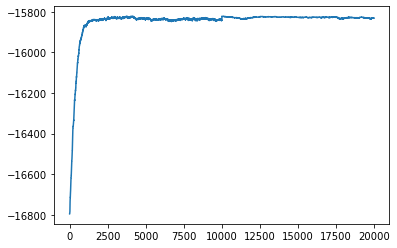

In [6]:
plt.plot(pVect)

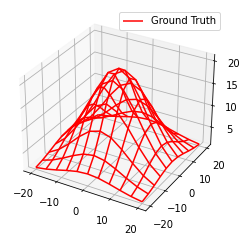

In [7]:
#initial = dVect[0]*np.ones(np.shape(xTemp))
#MAP = dVect[pVect.index(max(pVect))]*np.ones(np.shape(xTemp))
truth = dObserved.reshape(np.shape(xTemp))


fig = plt.figure()
bx = fig.add_subplot(projection='3d')

#bx.plot_wireframe(xTemp, yTemp, initial, rstride = 1, cstride = 1, color = 'c', label = 'Initial Guess')
#bx.plot_wireframe(xTemp, yTemp, MAP, rstride = 1, cstride = 1, color = 'k', label = 'MAP')
bx.plot_wireframe(xTemp, yTemp, truth, rstride = 1, cstride = 1, color = 'r', label = 'Ground Truth')
plt.legend()

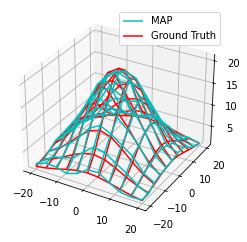

In [8]:
test = np.reshape(dVect[pVect.index(max(pVect))], np.shape(xTemp))
fig = plt.figure()
bx = fig.add_subplot(projection='3d')
bx.plot_wireframe(xTemp, yTemp, test, rstride = 1, cstride = 1, color = 'c', label = 'MAP')
bx.plot_wireframe(xTemp, yTemp, truth, rstride = 1, cstride = 1, color = 'r', label = 'Ground Truth')
plt.legend()

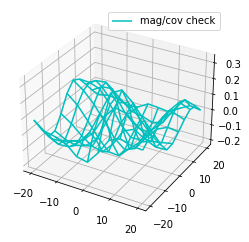

In [9]:

test1 = np.reshape((cMatChol @ np.random.randn(n))*.1, np.shape(xTemp))
fig = plt.figure()
bx = fig.add_subplot(projection='3d')
bx.plot_wireframe(xTemp, yTemp, test1, rstride = 1, cstride = 1, color = 'c', label = 'mag/cov check')
plt.legend()

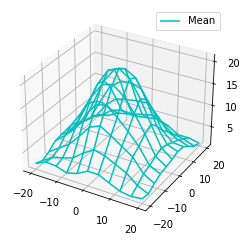

In [10]:
test2 = np.reshape(np.mean(dVect, axis = 0), (11,11))
fig = plt.figure()
bx = fig.add_subplot(projection='3d')
bx.plot_wireframe(xTemp, yTemp, test2, rstride = 1, cstride = 1, color = 'c', label = 'Mean')
plt.legend()

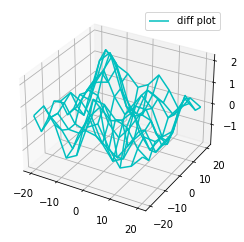

In [11]:
x = test-truth
fig = plt.figure()
bx = fig.add_subplot(projection='3d')
bx.plot_wireframe(xTemp, yTemp, x, rstride = 1, cstride = 1, color = 'c', label = 'diff plot')
plt.legend()

In [12]:
pVect.index(max(pVect))

10003

0.6149334418749568

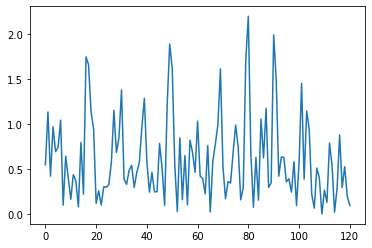

In [13]:
plt.plot(np.abs(np.reshape(x,-1)))
np.mean(np.abs(x))

In [14]:
#dOld = dObserved